In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import getpass

import os
from pathlib import Path

import itertools

from collections import Counter

In [210]:
def get_stat_outliers(sample, k=1.5, q_bottom=0.25, q_top=0.75, method='iqr'):
    '''Identifying outliers with the kxIQR rule or percentiles only
    Parameters:
        sample - series
        k - coefficient from IQR rule, default 1.5
        method - ‘iqr‘ or ‘quantiles‘ depending if iqr rule is used or not.
        If not then values about given quantiles returned
        q_bottom, q_top - bottom and top quantiles respectively
    '''
    
    q_bottom, q_top = sample.quantile([q_bottom, q_top])
    
    if method == 'quantiles':
        return q_bottom, q_top
    
    iqr = q_top - q_bottom
    min_iqr = q_bottom - k * iqr
    max_iqr = q_top + k * iqr
    
    return min_iqr, max_iqr

In [211]:
sns.set(style='darkgrid')

In [212]:
DATA_DIR = Path('/data', getpass.getuser(), 'kaggle', 'future_sales') #path to data files

sales = pd.read_csv(DATA_DIR / 'sales_train.csv')
items = pd.read_csv(DATA_DIR / 'items.csv')
item_categories = pd.read_csv(DATA_DIR / 'item_categories.csv')
shops = pd.read_csv(DATA_DIR /'shops.csv')

test = pd.read_csv(DATA_DIR / 'test.csv').set_index('ID')

In [213]:
test.columns

Index(['shop_id', 'item_id'], dtype='object')

In [214]:
items.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [215]:
sales.shape

(2935849, 6)

In [216]:
all_data = sales.merge(items, on='item_id')
all_data = all_data.merge(shops, on='shop_id')
all_data = all_data.merge(item_categories, on='item_category_id')
all_data.shape

(2935849, 10)

**Analysis**

In [160]:
all_data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,26.04.2013,3,59,944,150.00,1.00,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray


In [102]:
#count unique elements
print(all_data['item_id'].unique().shape[0], all_data['item_category_id'].unique().shape[0]
      , all_data['shop_id'].unique().shape[0], sep=' | ')

21807 | 84 | 60


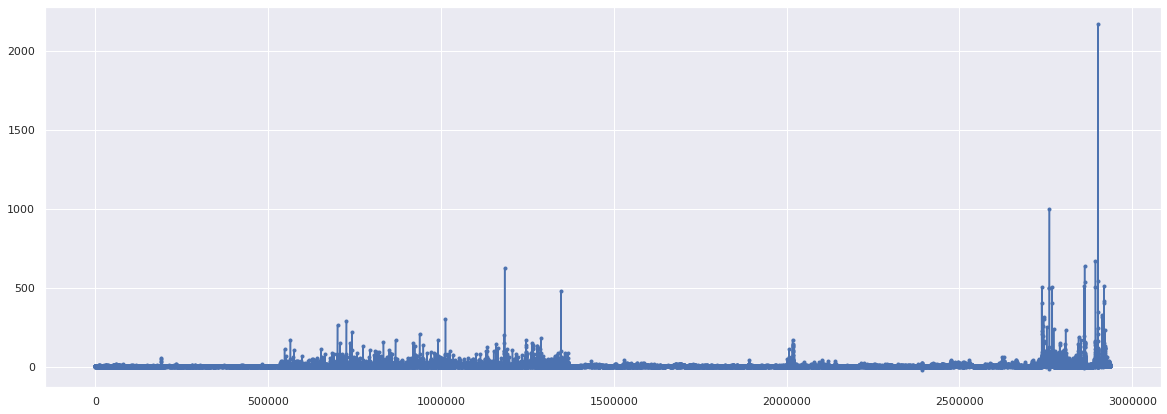

In [170]:
plt.figure(figsize=(20,7))
plt.plot(all_data['item_cnt_day'], marker='.')
plt.show()

In [208]:
xx = sorted(Counter(all_data['item_cnt_day']).items(), key=lambda x: x[1], reverse=True)
#check most popular val and number of objects in data
print(xx[0], xx[1], all_data.shape[0])
print(xx[0][1] + xx[1][1], all_data.shape[0])

(1.0, 2629372) (2.0, 194201) 2935849
2823573 2935849


We can see that cnt=1 is the biggest cnt of sales

**Look at shop**

In [103]:
for i, shop in enumerate(sorted(all_data['shop_name'].unique())):
    if (i+1) % 2:
        print(f"{shop:<47} - {all_data[all_data['shop_name']==shop]['shop_id'].to_numpy()[0]}", end='\t')
    else:
        print(f"{shop:<40} - {all_data[all_data['shop_name']==shop]['shop_id'].to_numpy()[0]}")

!Якутск Орджоникидзе, 56 фран                   - 0	!Якутск ТЦ "Центральный" фран            - 1
Адыгея ТЦ "Мега"                                - 2	Балашиха ТРК "Октябрь-Киномир"           - 3
Волжский ТЦ "Волга Молл"                        - 4	Вологда ТРЦ "Мармелад"                   - 5
Воронеж (Плехановская, 13)                      - 6	Воронеж ТРЦ "Максимир"                   - 7
Воронеж ТРЦ Сити-Парк "Град"                    - 8	Выездная Торговля                        - 9
Жуковский ул. Чкалова 39м?                      - 10	Жуковский ул. Чкалова 39м²               - 11
Интернет-магазин ЧС                             - 12	Казань ТЦ "Бехетле"                      - 13
Казань ТЦ "ПаркХаус" II                         - 14	Калуга ТРЦ "XXI век"                     - 15
Коломна ТЦ "Рио"                                - 16	Красноярск ТЦ "Взлетка Плаза"            - 17
Красноярск ТЦ "Июнь"                            - 18	Курск ТЦ "Пушкинский"                    - 19
Москва "Распродажа" 

Can see that there're duplicated shop_names with different shop_id, so fix it:

!Якутск Орджоникидзе, 56 фран | 0 = Якутск Орджоникидзе, 56 | 57

!Якутск ТЦ "Центральный" фран | 1 = Якутск ТЦ "Центральный" | 58

Жуковский ул. Чкалова 39м? | 10 = Жуковский ул. Чкалова 39м² | 11


In [104]:
all_data.loc[all_data['shop_id']==57, 'shop_id'] = 0
all_data.loc[all_data['shop_id']==58, 'shop_id'] = 1
all_data.loc[all_data['shop_id']==11, 'shop_id'] = 10

_Feature that can be created from above info is city_

In [106]:
all_data['shop_city'] = all_data['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.strip()
all_data['shop_city'] = all_data['shop_city'].apply(lambda x: x.split()[0])

**Look at categories**

In [107]:
for i, shop in enumerate(sorted(all_data['item_category_name'].unique())):
    if (i+1) % 2:
        print(f"{shop:<47} - {all_data[all_data['item_category_name']==shop]['item_category_id'].to_numpy()[0]}", end='\t')
    else:
        print(f"{shop:<40} - {all_data[all_data['item_category_name']==shop]['item_category_id'].to_numpy()[0]}")

PC - Гарнитуры/Наушники                         - 0	Аксессуары - PS2                         - 1
Аксессуары - PS3                                - 2	Аксессуары - PS4                         - 3
Аксессуары - PSP                                - 4	Аксессуары - PSVita                      - 5
Аксессуары - XBOX 360                           - 6	Аксессуары - XBOX ONE                    - 7
Билеты (Цифра)                                  - 8	Доставка товара                          - 9
Игровые консоли - PS2                           - 10	Игровые консоли - PS3                    - 11
Игровые консоли - PS4                           - 12	Игровые консоли - PSP                    - 13
Игровые консоли - PSVita                        - 14	Игровые консоли - XBOX 360               - 15
Игровые консоли - XBOX ONE                      - 16	Игровые консоли - Прочие                 - 17
Игры - PS2                                      - 18	Игры - PS3                               - 19
Игры - PS4          

_Feature than can be created is a root category and a type of goods. For example, Игры и PS2_

In [108]:
all_data['item_section_name'] = all_data['item_category_name'].apply(lambda x: x.lower().split('-')[0].split()[0].strip())

In [109]:
all_data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,shop_city,item_section_name
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ярославль,кино
1,26.04.2013,3,59,944,150.00,1.00,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ярославль,кино


In [110]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [111]:
all_data[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2935849.00,2935849.00
mean,890.85,1.24
std,1729.80,2.62
min,-1.00,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,307980.00,2169.00


In [112]:
all_data[all_data['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,shop_city,item_section_name
872646,15.05.2013,4,32,2973,-1.00,1.00,"DmC Devil May Cry [PS3, русские субтитры]",19,"Москва ТЦ ""Серебряный Дом""",Игры - PS3,москва,игры


In [113]:
#seems price less or eq zero is strange so i drop it
all_data = all_data[all_data['item_price'] > 0]

In [114]:
all_data[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2935848.00,2935848.00
mean,890.85,1.24
std,1729.80,2.62
min,0.07,-22.00
25%,249.00,1.00
50%,399.00,1.00
75%,999.00,1.00
max,307980.00,2169.00


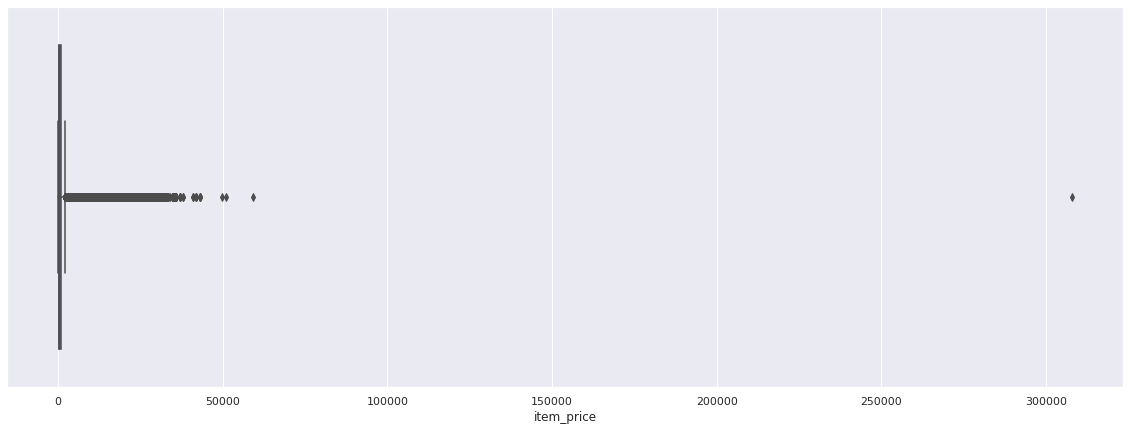

In [115]:
plt.figure(figsize=(20, 7))
sns.boxplot(all_data['item_price'])
plt.show()

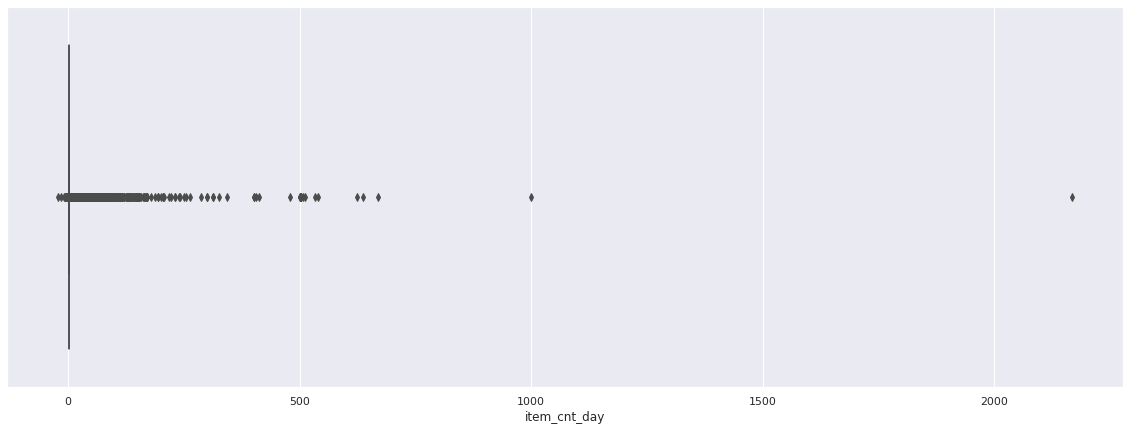

In [116]:
plt.figure(figsize=(20, 7))
sns.boxplot(all_data['item_cnt_day'])
plt.show()

In [118]:
#looks interesting
print(get_stat_outliers(all_data['item_price']), get_stat_outliers(all_data['item_cnt_day']))

(-876.0, 2124.0) (1.0, 1.0)


In [119]:
#try to go a bit deeper
print(get_stat_outliers(all_data['item_price'], q_bottom=0.01, q_top=0.99, method='quantiles'),
      get_stat_outliers(all_data['item_cnt_day'], q_bottom=0.01, q_top=0.999, method='quantiles'))

(5.0, 5999.0) (1.0, 22.0)


In [120]:
all_data[all_data['item_cnt_day'] > 900]['item_category_name'].unique()

array(['Подарки - Сумки, Альбомы, Коврики д/мыши', 'Доставка товара'],
      dtype=object)

In [121]:
all_data[all_data['item_price'] > 60000]['item_category_name'].unique()

array(['Программы - Для дома и офиса'], dtype=object)

In [122]:
#get rid of those objects but may be it's better to keep due to clipping to [0,20] all values of cnt
all_data = all_data[(all_data['item_cnt_day'] <= 900) & (all_data['item_price'] <= 60000)]

In [123]:
all_data.shape

(2935845, 12)

In [124]:
#month as a feature
all_data['month'] = pd.to_datetime(all_data['date'], format='%d.%m.%Y').apply(lambda x: x.month)

In [125]:
all_data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,shop_city,item_section_name,month
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ярославль,кино,1
1,26.04.2013,3,59,944,150.00,1.00,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,ярославль,кино,4


In [144]:
all_data['date_block_num'].max()

33

In [151]:
all_data.loc[all_data['date_block_num']==33, 'date'].to_numpy()[0]

'31.10.2015'

More feature generation I'll do in another file

### Test
it's date_block_num is 34: it's 11'th month

In [128]:
test['item_id'].value_counts().unique()

array([42])

In [130]:
test['shop_id'].value_counts().unique()

array([5100])

In [141]:
test.shape, test.drop_duplicates().shape

((214200, 2), (214200, 2))

### Aggregated

In [217]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []

for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


# Aggregations
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,20) #seems it's better to clip here
train = sales.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
            .agg({'item_cnt_day':'sum', 'item_price':'mean'})
train = train.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
train['item_cnt_month'] = train['item_cnt_month'].clip(0,20) #one more clip

#merge aggregated sales and grid
train = pd.merge(grid, train, how='left',on=index_cols)
train['item_cnt_month'] = train['item_cnt_month'].fillna(0)

In [223]:
xx = sorted(Counter(train['item_cnt_month']).items(), key=lambda x: x[1], reverse=True)
#check most popular val and number of objects in data
print(xx[0], xx[1], train.shape[0])
print(xx[0][1] + xx[1][1], train.shape[0])

(0.0, 9305624) (1.0, 1060054) 10913850
10365678 10913850


Check some basic predictions

In [18]:
ans = pd.DataFrame({'item_cnt_month': [0] * len(test)})
ans.insert(0, 'ID', ans.index)
ans.to_csv(DATA_DIR / 'answer1.csv', index=False)
#get 1.25011

In [224]:
ans = pd.DataFrame({'item_cnt_month': [0.5] * len(test)})
ans.insert(0, 'ID', ans.index)
ans.to_csv(DATA_DIR / 'answer2.csv', index=False)
#1.235453

In [225]:
ans = pd.DataFrame({'item_cnt_month': [0.25] * len(test)})
ans.insert(0, 'ID', ans.index)
ans.to_csv(DATA_DIR / 'answer3.csv', index=False)
#1.21791